In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta as rd


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with = engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(bind = engine)

In [9]:
#Exploring Database
inspector= inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types in measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types in station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date =session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.

recent_date_dateformat = dt.datetime.strptime(recent_date, "%Y-%m-%d")

one_year_before = recent_date_dateformat - rd(years=1)
one_year_before


datetime.datetime(2016, 8, 23, 0, 0)

In [14]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names

rows = session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp)\
.filter(Measurement.date>='2016-08-23').all()
measurement_df = pd.DataFrame(rows)
measurement_df.head()

,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,2365,USC00519397,2016-08-24,0.08
2,2366,USC00519397,2016-08-25,0.08
3,2367,USC00519397,2016-08-26,0.00
4,2368,USC00519397,2016-08-27,0.00


In [ ]:
# Sort the dataframe by date

measurement_df = measurement_df.sort_values(by = "date")
measurement_df.head()

<Figure size 1000x600 with 0 Axes>

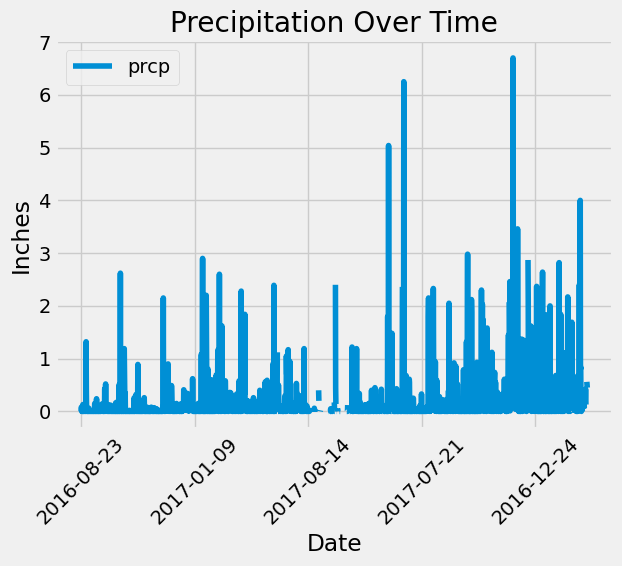

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))  
measurement_df.plot(x='date', y='prcp', kind='line', linestyle='-', title='Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45) 
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurement_df.describe()

,id,prcp
count,2230.000000,2021.000000
mean,10158.570404,0.177279
std,5603.500203,0.461190
min,2364.000000,0.000000
25%,5287.250000,0.000000
50%,8930.500000,0.020000
75%,14750.750000,0.130000
max,19550.000000,6.700000


# Exploratory Station Analysis

In [17]:
# Get a list of column names and types in station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [19]:
station_name = session.query(Station.station).all()
for names in station_name:
    print(names[0])

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_maxrow = session.query(Measurement.station, func.count(Measurement.id).label('count')) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.id).desc())
for station, count in station_maxrow:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_maxrowfirst = session.query(Measurement.station, func.count(Measurement.id).label('count')) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.id).desc()).first()
# Get the station ID 
most_active_station = station_maxrowfirst[0]  

temperature_stats = session.query(func.min(Measurement.tobs).label('min_temp'),func.max(Measurement.tobs).label('max_temp'),\
    func.avg(Measurement.tobs).label('avg_temp')).filter(Measurement.station == most_active_station).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_one_year = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
                  filter(Measurement.station == most_active_station).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all()
temp_df = pd.DataFrame(temp_one_year)
temp_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


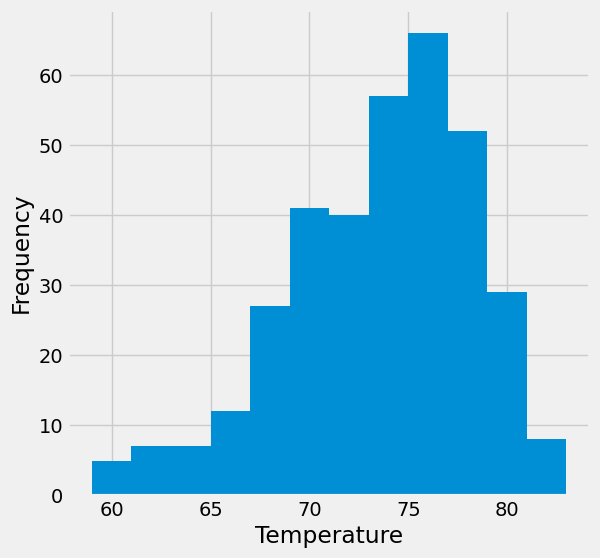

In [23]:
# histogram plot
plt.figure(figsize=(6, 6))  
temp_df['tobs'].plot(kind='hist',bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [24]:
# Close Session
session.close()
